This notebook provides starter code for the localization task with Holo1-7B model: i.e. image + instruction -> click coordinates


In [1]:
import json
import os
import re
import requests
from typing import Any, Literal
from PIL import Image, ImageDraw
from IPython.display import display
from transformers.models.qwen2_vl.image_processing_qwen2_vl import smart_resize
from transformers import AutoModelForImageTextToText, AutoProcessor
from huggingface_hub import hf_hub_download

2025-06-06 13:40:43.046975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749217243.272661      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749217243.341766      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
HF_MODEL_REPO = "Hcompany/Holo1-7B"

## Prepare model, processor

In [3]:
# default: Load the model on the available device(s)
# We recommend enabling flash_attention_2 for better acceleration and memory saving.
model = AutoModelForImageTextToText.from_pretrained(
    HF_MODEL_REPO,
    torch_dtype="auto",
    # torch_dtype=torch.bfloat16,
    # attn_implementation="flash_attention_2",
    device_map="auto",
)

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [4]:
# default processor
processor = AutoProcessor.from_pretrained(HF_MODEL_REPO)
# The default range for the number of visual tokens per image in the model is 4-1280.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# processor = AutoProcessor.from_pretrained(model_dir, min_pixels=min_pixels, max_pixels=max_pixels)

preprocessor_config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.92k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

In [5]:
# Helper function to run inference
def run_inference(messages: list[dict[str, Any]]) -> str:
    # Preparation for inference
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(
        text=[text],
        images=image,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    return processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)

## Prepare image and instruction

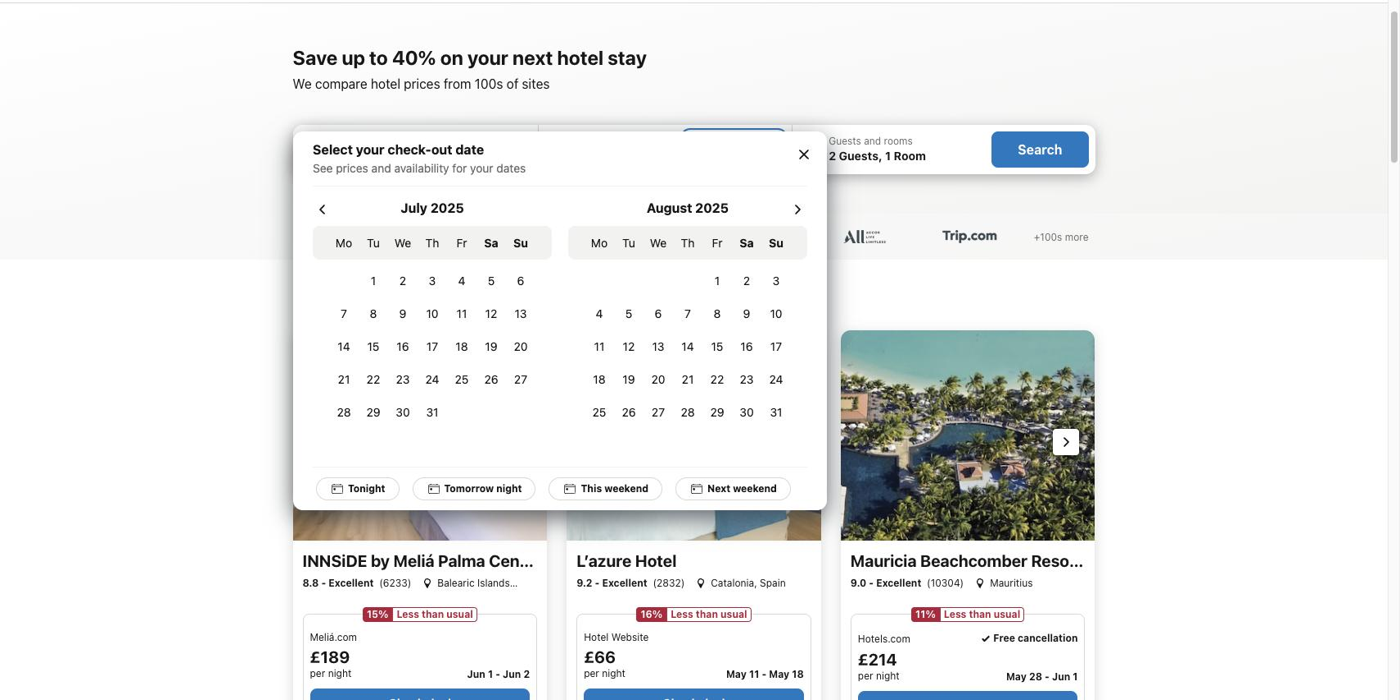

In [6]:
# Prepare image and instruction
image_url = "https://huggingface.co/{}/resolve/main/calendar_example.jpg".format(HF_MODEL_REPO) 
image = Image.open(requests.get(image_url, stream=True).raw)

# Resize the image so that predicted absolute coordinates match the size of the image.
image_processor = processor.image_processor
resized_height, resized_width = smart_resize(
    image.height,
    image.width,
    factor=image_processor.patch_size * image_processor.merge_size,
    min_pixels=image_processor.min_pixels,
    max_pixels=image_processor.max_pixels,
)
image = image.resize(size=(resized_width, resized_height), resample=None)  # type: ignore

display(image)

## Localization with click(x, y)

In [7]:
hf_hub_download(repo_id=HF_MODEL_REPO, filename="localization.py", local_dir=os.getcwd())

localization.py:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

'/kaggle/working/localization.py'

In [8]:
import localization

instruction = "Select July 14th as the check-out date"
prompt = localization.get_localization_prompt(image, instruction)
coordinates = run_inference(prompt)[0]
print(coordinates)
# Expected Click(352, 348)

Click(350, 352)


In [9]:
def draw_crosses_at(image, x, y, width = 3, delta = 10):
    draw = ImageDraw.Draw(image)
    draw.line([(x-delta, y-delta), (x+delta, y+delta)], width=width, fill="red")
    draw.line([(x-delta, y+delta), (x+delta, y-delta)], width=width, fill="red")
    display(image)

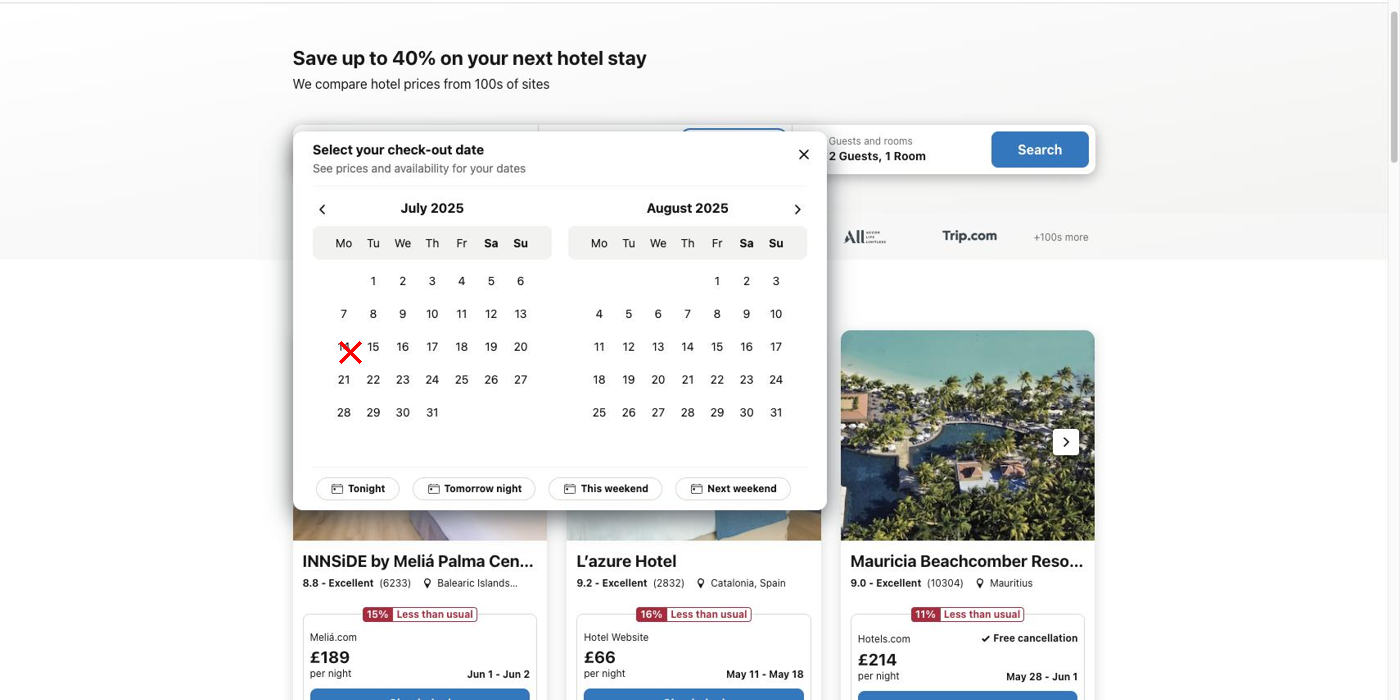

In [10]:
match = re.search('Click\((\d+)\, (\d+)\)', coordinates, re.IGNORECASE)
x, y = [int(x) for x in match.groups(0)]
draw_crosses_at(image, x, y)

## Localization with Structured Output

We trained Holo1 as an Action VLM with extensive use of json and tool calls. Therefore, it can be queried reliably with structured output:

In [11]:
instruction = "Select July 14th as the check-out date"
prompt = localization.get_localization_prompt_structured_output(image, instruction)
coordinates_structured_str = run_inference(prompt)[0]
coordinates_structured = localization.ClickAction(**json.loads(coordinates_structured_str)["arguments"])
print(coordinates_structured)
# Expected ClickAction(action='click', x=352, y=340)

action='click' x=370 y=352


In [12]:
print(json.loads(coordinates_structured_str))

{'name': 'ClickAction', 'arguments': {'action': 'click', 'x': 370, 'y': 352}}


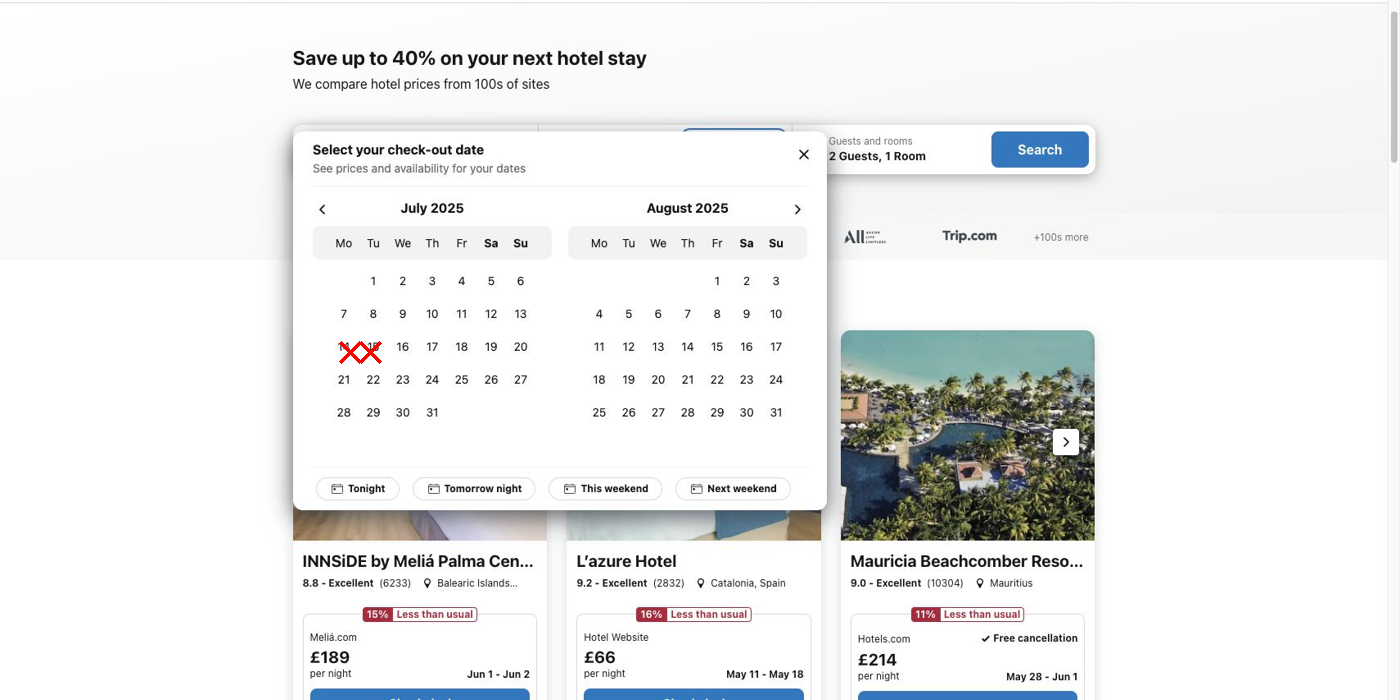

In [13]:
draw_crosses_at(image, coordinates_structured.x, coordinates_structured.y)